The goal here is to check if the [Von Mises distribution](https://en.wikipedia.org/wiki/Von_Mises_distribution) is the *a priori* choice to make when handling polar coordinates. 

<!-- TEASER_END -->

Let's first initialize the notebook:

In [1]:
import numpy as np
np.set_printoptions(precision=6, suppress=True)
import os
%matplotlib inline
%config InlineBackend.figure_format='retina'
#%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
phi = (np.sqrt(5)+1)/2
fig_width = 8
figsize = (fig_width, fig_width/phi)

In [2]:
N = 100
m_x, m_y = 5., 3
sigma_x, sigma_y = 1., .2
x, y = m_x + sigma_x*np.random.randn(N), m_y + sigma_y*np.random.randn(N)

In [3]:
x.min(), x.max()

(2.820144666397773, 7.2729148634051946)

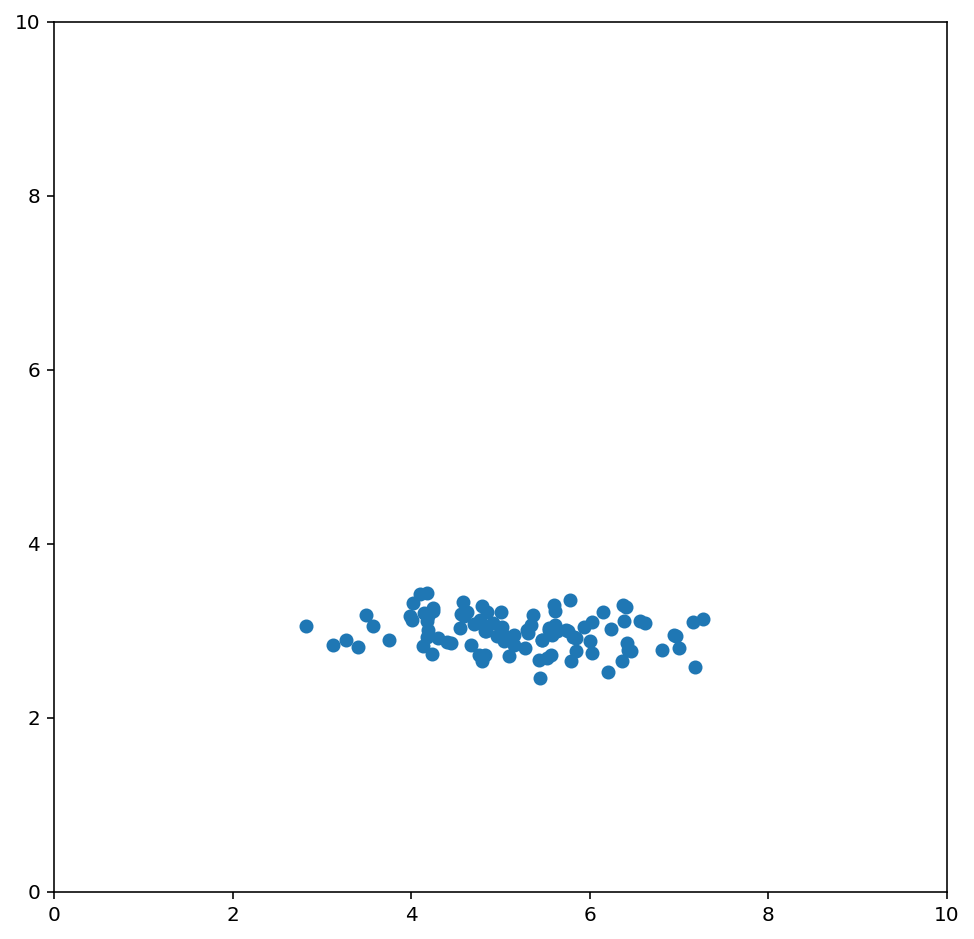

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width))
ax.scatter(x, y)
ax.set_xlim(0, 10)
ax.set_ylim(0, 10);

Let's do the same visualization but now transformed into polar coordinates:

In [5]:
r = np.sqrt(x**2 + y**2)
theta = np.arctan2(y, x)

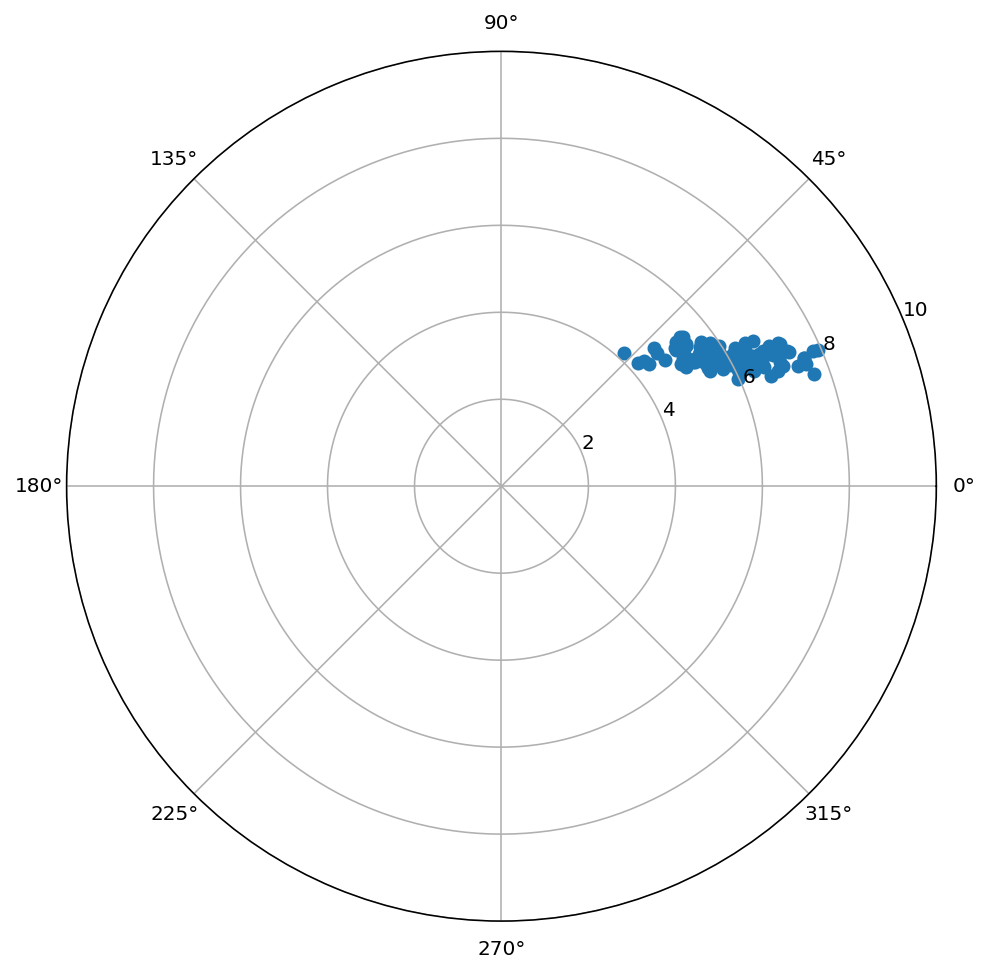

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width), subplot_kw=dict(polar=True))
ax.scatter(theta % np.pi, r);
ax.set_ylim(0, 10);

## projection on the ring: the von Mises distribution

Let's now do the histogram of these values in the polar space of angles:

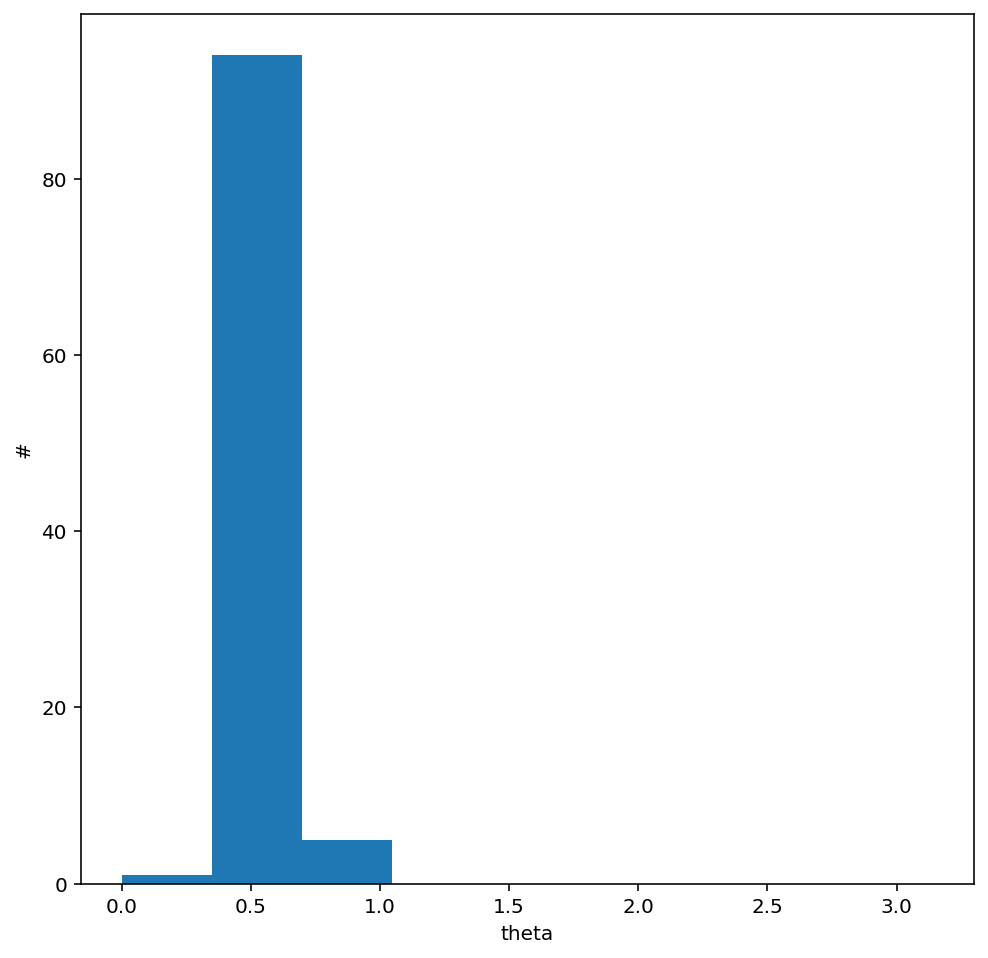

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width))
ax.hist(theta, bins=np.linspace(0, np.pi, 10));
ax.set_xlabel('theta')
ax.set_ylabel('#');
#ax.set_ylim(0, 10);

Can we fit it with a [Von Mises distribution](https://en.wikipedia.org/wiki/Von_Mises_distribution)?


In [8]:
N = 100000
N_bins = 128
m_x, m_y = 5., 3
sigma_x, sigma_y = 1., .2
x, y = m_x + sigma_x*np.random.randn(N), m_y + sigma_y*np.random.randn(N)

In [9]:
r = np.sqrt(x**2 + y**2)
theta = np.arctan2(y, x)

In [10]:
bins = np.linspace(0, np.pi, N_bins)
v_hist, v_edges = np.histogram(theta, bins=bins, density=True);
v_hist.shape, v_edges.shape

((127,), (128,))

In [11]:
def VonMises(theta, amp, theta0, Btheta):
     return amp * np.exp((np.cos(2*(theta-theta0))-1) / 4 / Btheta**2)

[[Model]]
    Model(VonMises)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 71
    # data points      = 127
    # variables        = 3
    chi-square         = 1.53015555
    reduced chi-square = 0.01233996
    Akaike info crit   = -555.189847
    Bayesian info crit = -546.657285
[[Variables]]
    amp:     4.37986959 +/- 0.05395009 (1.23%) (init = 1)
    theta0:  0.53369593 +/- 0.00126487 (0.24%) (init = 1.5)
    Btheta:  0.08857842 +/- 0.00125485 (1.42%) (init = 0.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, Btheta) = -0.577



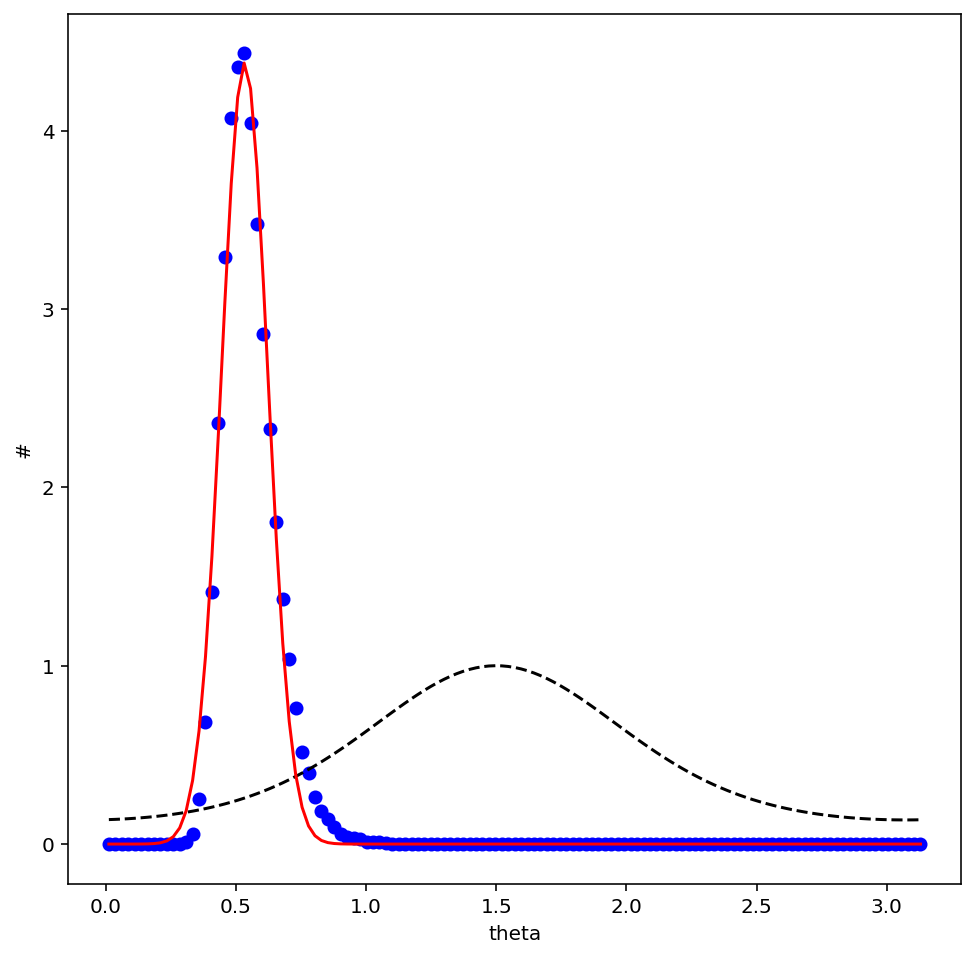

In [12]:
from lmfit import Model

theta = .5*( bins[1:] + bins[:-1] )
vm_model = Model(VonMises)
result = vm_model.fit(v_hist, theta=theta, amp=1., theta0=1.5, Btheta=.5)

print(result.fit_report())

fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width))
ax.plot(theta, v_hist, 'bo')
ax.plot(theta, result.init_fit, 'k--')
ax.plot(theta, result.best_fit, 'r-')
ax.set_xlabel('theta')
ax.set_ylabel('#');

Seems pretty good... Let's test for a larger set of Gaussian distributions with random parameters:

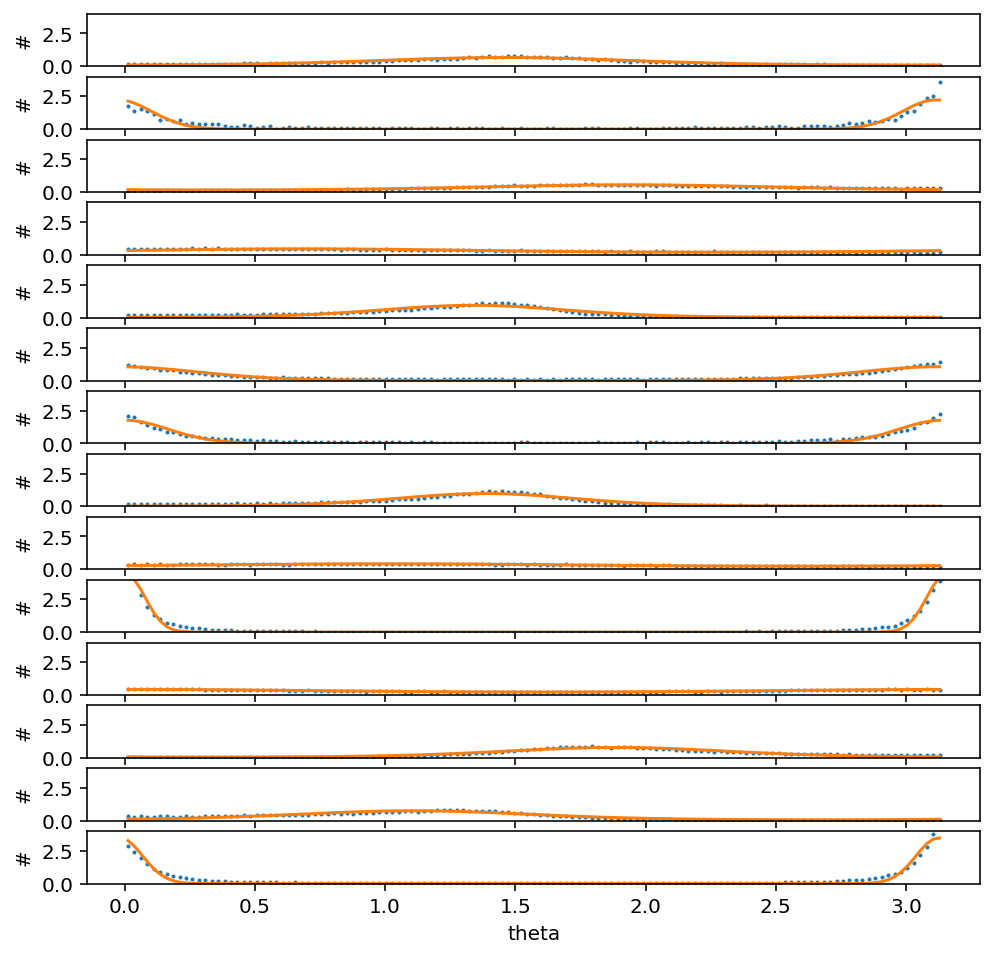

In [13]:
N_try = 14
fig, axs = plt.subplots(N_try, 1, figsize=(fig_width, fig_width))
np.random.seed(42)
redchis, Bthetas = [], []
M, S = .25, 1.
for ax in axs:
    m_x, m_y = M*np.random.randn(), M*np.random.randn()
    sigma_x, sigma_y = S*np.random.randn(), S*np.random.randn()
    
    x, y = m_x + sigma_x*np.random.randn(N), m_y + sigma_y*np.random.randn(N)
    thetas = np.arctan2(y, x)

    v_hist, v_edges = np.histogram(thetas, bins=bins, density=True);

    vm_model = Model(VonMises)
    result = vm_model.fit(v_hist, theta=theta, amp=3., theta0=1.5, Btheta=.5)
    #print(result.fit_report())

    redchis.append(result.redchi)
    Bthetas.append(np.abs(result.best_values['Btheta']))
    ax.plot(theta, v_hist, 'o', ms=1)
    ax.plot(theta, result.best_fit, '-')

    ax.set_xlabel('theta')
    ax.set_ylim(0, 4);
    ax.set_ylabel('#');    

In [14]:
print('redchis=', np.mean(redchis), ' +/-', np.std(redchis))

redchis= 0.012617038040843189  +/- 0.013608170699675213


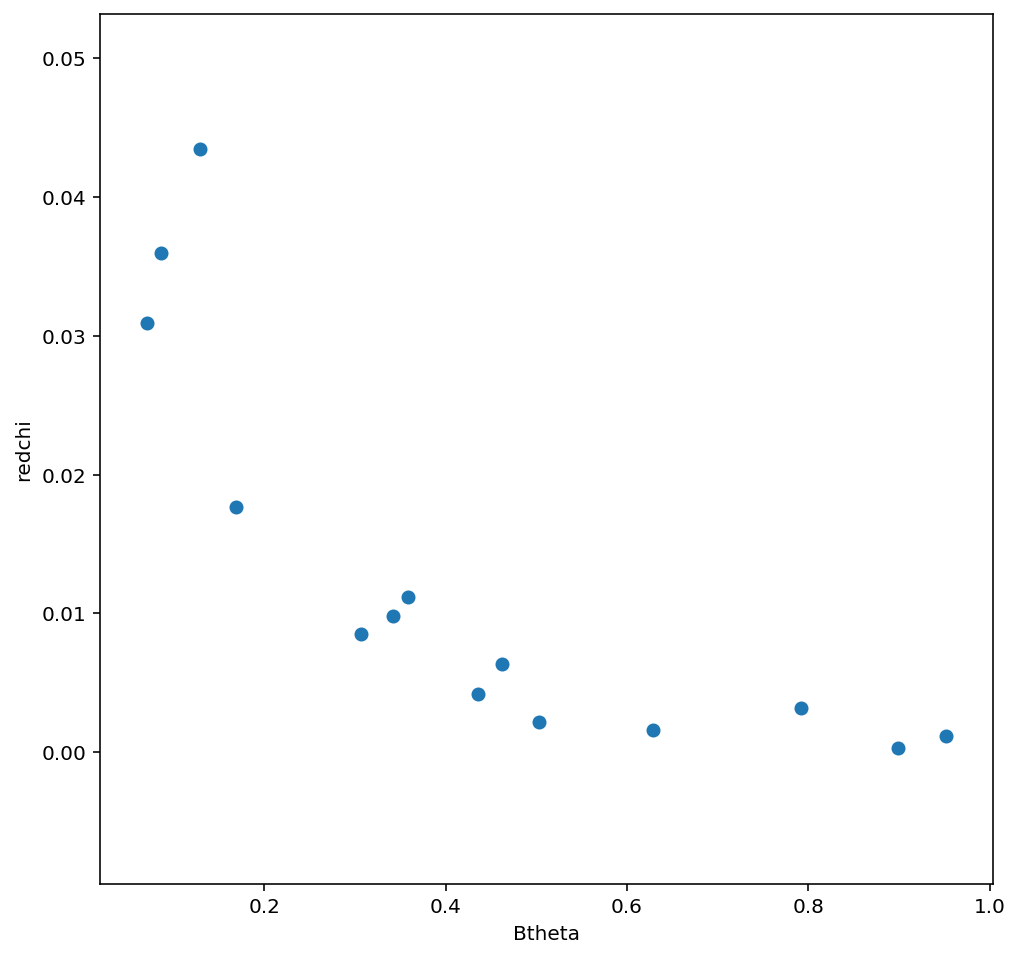

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width))
ax.scatter(Bthetas, redchis)
ax.set_xlabel('Btheta')
ax.set_ylabel('redchi');

Pretty good, but not perfect (especially for peaked distributions) ...

Yet, in [Wang, F., and Gelfand, A. E. 2013. Directional data analysis under the general projected normal distribution. Statistical methodology 10(1):113–127.](https://europepmc.org/articles/pmc3773532), it is claimed that :

> The von Mises distribution is the maximum entropy distribution on the circle for a fixed mean direction and dispersion and can be considered as an analogue of the normal distribution on the real line.

Still, I have nbo proof for that - this would certainly begin with a 
[change of variables](https://en.wikipedia.org/wiki/Probability_density_function#Dependent_variables_and_change_of_variables)

Is there something better?

## some book keeping for the notebook

In [16]:
%load_ext watermark
%watermark -i -h -m -v -p numpy,matplotlib,torch  -r -g -b

2019-06-12T21:12:23+02:00

CPython 3.7.3
IPython 7.5.0

numpy 1.16.4
matplotlib 3.1.0
torch 1.1.0

compiler   : Clang 10.0.0 (clang-1000.11.45.5)
system     : Darwin
release    : 17.7.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit
host name  : ada
Git hash   : cfbf80e5b427f60fb9c39688f5b895fb2b35ee6a
Git repo   : https://github.com/laurentperrinet/sciblog.git
Git branch : master
